# Fast approximate simulation of seismic waves with deep learning

# Machine learning workshop


---

Author: Ben Moseley, Centre for Autonomous Intelligent Machines and Systems, University of Oxford, bmoseley@robots.ox.ac.uk 

This workshop reproduces the results of the paper: *[Fast approximate simulation of seismic waves with deep learning](https://arxiv.org/abs/1807.06873), NeurIPS 2018, B. Moseley, A. Markham and T. Nissen-Meyer*.

Last updated: Jan 2019

---

<img src="figures/header.png" width=600>


## Overview

- **Seismic simulation** is crucial for many geophysical applications, yet traditional approaches are **computationally expensive**.

- In this workshop, we will use **deep learning** to simulate seismic waves.

- We will show that this can offer a **fast approximate alternative** to traditional simulation methods.

---

This workshop takes ~ 1-2 hrs to complete. All the code for this notebook can be found here: https://github.com/benmoseley/seismic-simulation-wavenet

---

## Task

For this proof of principle study, we will consider the simulation of **acoustic waves** propagating in synthetic **horizontally layered** media.

Specifically, we will consider a single fixed point source propagating through a horizonally layered velocity model with 11 fixed receivers horizontally offset from the source, shown below.

<img src="figures/example_simulation.png" width=600>

Left: input velocity model, triangles show receiver locations. Right: wavefield pressure after 1 s, using acoustic Finite-Difference (FD) modelling,  black circle shows fixed point source location.

Our task is as follows:

> Given a randomly selected layered velocity model as input, can we train a neural network to simulate the pressure response recorded at each receiver location?

We wish our neural network to generalise well to velocity models unseen during training. We will compare our results to traditional FD modelling.


## Workflow

We will use the following workflow to complete this task;

- we will preprocess the input velocity profile into its corresponding reflectivity series;

- we will pass this to a deep neural network with a **WaveNet** architecture to simulate the receiver responses;

- we will train this network with many example ground truth FD simulations;

- we will compare the accuracy and computational performance of the trained network to FD simulation.

This workflow is shown below.

<img src="figures/workflow.png" width=850>


## Sections

There are 5 sections to complete in this notebook. This is an interactive notebook; during each section you will be asked to complete some short coding tasks and answer some questions as you go along.

The sections are as follows:

- Section 1: Data loading and exploration

- Section 2: Designing a deep learning model

- Section 3: Training the model

- Section 4: Evaluating performance

- Section 5: Seismic inversion (optional extra)



## Installation

### 1. Python enviroment

This notebook only requires Python libraries to run. We recommend setting up an new environment, for example
```bash
conda create -n workshop python=3.6  # Use anaconda package manager
source activate workshop
```
and then installing the following dependencies:
```bash
pip install tensorflow tqdm requests
conda install matplotlib jupyter
```

then downloading the source code:

```bash
git clone https://github.com/benmoseley/seismic-simulation-wavenet.git
```

Finally, check your environment is set up correctly by importing the required libraries for this notebook:

In [1]:
# import libraries
import os, time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import main, models, datasets, constants
import io_utils, downloader

### 2. Downloading data

This notebook requires access to a pre-made dataset for training and testing our deep neural network, as well as some pretrained tensorflow model files.

Please use the code below to download this data.

Note: the file size of the seismic dataset is **~600 Mb** and the file size of the pretrained files are **~100 Mb** - ensure you have enough disk space beforehand!

Please **unzip** the pretrained model files after downloading.

In [2]:
## Download the training data and pretrained model files (~700 Mb total)
io_utils.get_dir("data/")# create data directory
if not os.path.isfile("data/layers_8ms.bin"):# download data
    downloader.get_url(url="https://benmoseley.blog/uploads/DIP/layers_8ms.bin",
                       file_path="data/layers_8ms.bin")
if not (os.path.isfile("data/pretrained.zip") or os.path.isdir("data/pretrained")):# download pretrained model files
    downloader.get_url(url="https://benmoseley.blog/uploads/DIP/pretrained.zip",
                       file_path="data/pretrained.zip")# please unzip this folder after downloading

# Section 1: Data loading and exploration

In this section we will explore the downloaded dataset. This dataset contains 20,000 example simulations which we will use to train and test our deep neural network.

Each example simulation consists of a horizontally layered velocity model, its corresponding zero-offset reflectivity series and the pressure recorded at each receiver location. The pressure response has been simulated offline using the velocity model and 2D acoustic finite difference modelling. The reflectivity series has also been precomputed offline for you using the velocity model and  a simple 1-D depth to time conversion.

> **Task 1:** use `matplotlib` to visualise some of the examples.

Note:

- the velocity model is sampled in depth with a spacing of 12.5 m;
- the reflectivity model and receiver recordings are sampled in time with a sample rate of 0.008 s;
- The receiver spacing is 200 m.


20000
<class 'numpy.ndarray'> (236, 1)
<class 'numpy.ndarray'> (600, 11)


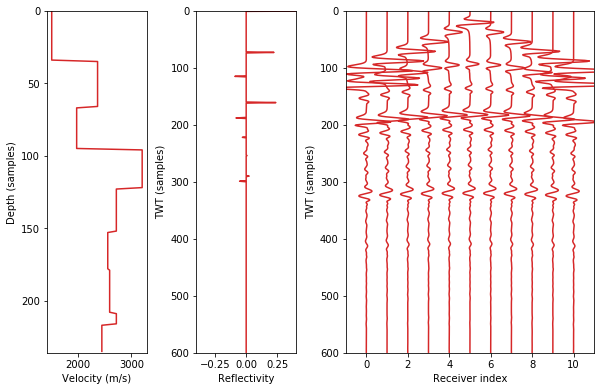

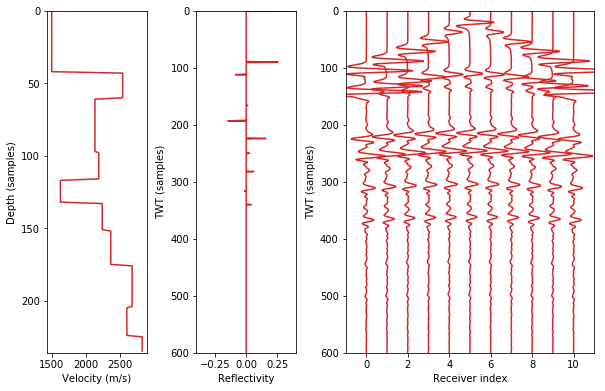

In [3]:
### TODO: run the following code to read the provided dataset into Python.
# Note: data/layers_8ms.bin is a flat binary file containing all of the examples.
# The datasets.SeismicDataset class loads examples from the binary file into numpy arrays.
# The constants.Constants class feeds necessary constants to the SeismicDataset class.

# define constants
c = constants.Constants()
c["DATA_PATH"]="data/layers_8ms.bin"# path to dataset
c["N_EXAMPLES"]=20000# number of examples in dataset
c["VELOCITY_SHAPE"]=(236, 1)# (Number of depth steps, 1)
c["REFLECTIVITY_SHAPE"]=(600, 1)# (Number of time steps, 1)
c["GATHER_SHAPE"]=(600, 11)# (Number of time steps, Number of receivers)

# create a SeismicDataset object
dataset = datasets.SeismicDataset(c)
print(len(dataset))

# get the first example from the dataset
velocity_array, reflectivity_array, gather_array = dataset[0]
print(type(velocity_array), velocity_array.shape)
print(type(gather_array), gather_array.shape)

### TODO: Enter you code to visualise a few of the examples here:

for i in [10,20]:
    datasets.plot_example(*dataset[i])
    plt.show()

> **Question 1:** what formula should be used for converting velocity models to their (zero offset) reflectivity series?

Note: a constant density model was used during simulation. You can check the precomputed reflectivity series are correct by calculating you own reflectivity series and comparing them.

> *Answer: the formula for the reflectivity value at normal incidence is*
$$
R = {\rho_{2}v_{2}-\rho_{1}v_{1} \over \rho_{2}v_{2}+\rho_{1}v_{1}}~,
$$
*where $\rho_{1}$,$v_{1}$ and $\rho_{2}$,$v_{2}$ are the densities and velocities across the interface.*

> **Task 2:** plot the histograms of layer velocity values and layer thicknesses across the entire dataset.

Note: the provided velocity models all start at 1500 m/s which leads to a spike in the velocity histogram at this value.

163219 143219


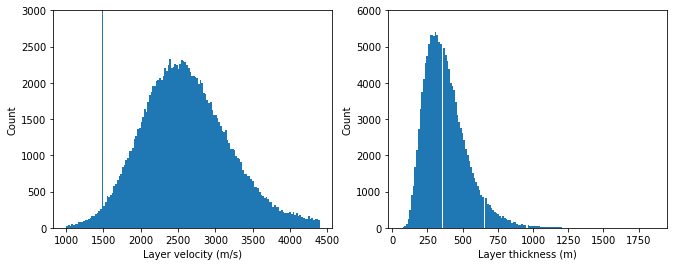

In [4]:
### TODO: Enter you code here:
# Hint: you can plt.hist to make the histogram

layer_velocities = []
layer_thicknesses = []
for i in range(len(dataset)):
    velocity_array, _, _ = dataset[i]
    v = None
    tstart = 0
    for ival, val in enumerate(velocity_array):
        if v == None: 
            v = val
            layer_velocities.append(v)
        if v != val:
            v = val
            layer_velocities.append(v)
            layer_thicknesses.append(12.5*(ival - tstart))
            tstart = ival
            
layer_velocities = np.array(layer_velocities)
layer_thicknesses = np.array(layer_thicknesses)
print(len(layer_velocities), len(layer_thicknesses))

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.hist(layer_velocities, bins=150)
plt.xlabel("Layer velocity (m/s)")
plt.ylabel("Count")
plt.ylim(0, 3000)

plt.subplot(1,2,2)
plt.hist(layer_thicknesses, bins=150)
plt.xlabel("Layer thickness (m)")
plt.ylabel("Count")
plt.ylim(0, 6000)
plt.show()

# Section 2: Designing a deep learning model

We will now define a deep neural network which can simulate the receiver responses, given a velocity model as input.

For a horizontally layered velocity model and horizontally offset receivers, each receiver response is **causally correlated** to the reflectivity series. More precisely, each pressure sample in time is at most correlated to the reflectivity values from previous times. 

We will model the receiver responses using a network which honours this casual relationship. Here, we will choose a **WaveNet** design, shown in the figure below. This architecture was originally designed for speech synthesis (for more info see here: https://deepmind.com/blog/wavenet-generative-model-raw-audio/).

<img src="figures/wavenet.png" width=500>

This model consists of **stacked, casually connected, exponentially dilated convolutional layers**.  The model is causal by design and the exponential dilations allow the field of view of the network to increase exponentially with the depth of the network. 

The input to the WaveNet is the preprocessed reflectivity series corresponding to the input velocity model and the output of the WaveNet is passed to a **final causal convolutional layer with no activation** to generate the output receiver pressure predictions. Each channel in the output tensor corresponds to a receiver prediction.


There are a number of key hyperparameters to decide in this model, including:

- number of hidden layers
- number of hidden channels
- activation function
- filter length of the final convolutional layer

> **Task 3:** define a WaveNet model in Tensorflow and visualise the graph using Tensorboard. 

In [5]:
### TODO: Run the code below to define a WaveNet model.
### TODO: Vary the hyperparameters of the model to see how this affects the model graph in Tensorboard.
### TODO: Look through the source code of wavenet.py and try to understand how the WaveNet is defined.
### the WaveNet source code is also available here: https://github.com/benmoseley/simple-wavenet.

# Note:
# The constants.Constants class is used to hold all model hyperparameters
# The models.SeismicWavenet class is used to define a WaveNet model in tensorflow

tf.reset_default_graph()

# define model hyperparameters
c = constants.Constants()
c["NUM_WAVE_BLOCKS"] = 1# number of WaveNet blocks to use
c["WAVE_HIDDEN_CHANNELS"] = 256# number of hidden channels in WaveNet
c["WAVE_RATES"] = [1,2,4,8,16,32,64,128,256]# dilation rates for each convolutional layer
c["WAVE_BIASES"] = False# whether to use biases in the WaveNet
c["WAVE_ACTIVATION"] = tf.nn.relu# activation function
c["CONV_FILTER_LENGTH"] = 101# filter length of the final output convolutional layer

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define model graph
model = models.SeismicWavenet(c, input_features)
model.define_graph()
print(model.y.shape)# the output tensor of the model - check this is the right shape!

# save graph to events file for tensorboard visualisation
io_utils.get_dir("wavenet_graph/")# create data directory
io_utils.clear_dir("wavenet_graph/")# careful - clears all files in this directory
summary_writer = tf.summary.FileWriter("wavenet_graph/",
                                       filename_suffix=".wavenet_graph")# write events file to current directory
with tf.Session() as sess: summary_writer.add_graph(sess.graph)
summary_writer.close()

# hint: use tensorboard --logdir . to lauch tensorboard and visualise the graph

(?, 600, 11)


> **Question 2:** what does the first dimension of the output tensor (model.y) define?

> *Answer: the number of examples in the mini-batch.*

> **Question 3:** how does changing the number of hidden channels affect the network?

> *Answer: this increases the number of parameters in the model. It makes the WaveNet "wider": more parallel computations are carried out at each layer of the network.*

> **Question 4:** why do we left-pad each input layer before carrying out a convolution?

> *Answer: left-padding ensures that the convolution is causal.*

> **Question 5:** why is the final output convolutional layer important?

> *Answer: we need an output layer without an activation function to regress the pressure values, which can be < 0.*

> **Question 6:** what are the total number of trainable parameters in your model?

> *Answer: (see code below)*

In [6]:
### TODO: Write some code to answer to Question 6 here:

# hint: tf.trainable_variables() lists all trainable variables

print(model)

Wavenet:
	Number of weights: 1049088
	Number of biases: 0
Conv1d:
	Number of weights: 284416
	Number of biases: 11
Total number of trainable parameters: 1333515


# Section 3: Training the model

In this section we will train the WaveNet model we defined in Section 2.

We will use an Adam optimiser with mini-batches of examples, and an $l_{p}$-norm loss function of the form:

$$
L = {1\over N} \lVert G(\hat{Y} - Y)\rVert_{p}^{p}~,
$$

Where $N$ is the mini-batch size, $\hat{Y}$ are the predicted receiver responses, $Y$ are the true receiver responses from FD simulation and $G$ is a gain function of the form $G=t^{2}$, where $t$ is the sample time.

We use this heuristic gain function to increase the weight of later time samples in the pressure responses which are attenuated by spherical divergence and transmission loss.

We will use the first 80% of the data to train the model and withhold the last 20% for testing.

> **Task 4:** define a loss function and optimiser for your model, and visualise the graph using Tensorboard.

In [7]:
### TODO: Run the code below to define a loss function and optimiser.
### Read through the model.define_loss() source code in models.py to see how
### the loss function and the optimiser operation are defined.
### Visualise the graph using Tensorboard.

# define loss and optimiser hyperparameters
c["BATCH_SIZE"] = 20# number of examples in each min-batch
c["LRATE"] = 1e-5# learning rate for Adam
c["T_GAIN"] = 2# gain exponent
c["L_NUM"] = 2# LP loss number (1 = L1 loss, 2 = L2 loss)

# define loss and optimiser in graph
model.define_loss()

# save graph to events file for tensorboard visualisation
io_utils.get_dir("wavenet_graph_with_loss/")# create data directory
io_utils.clear_dir("wavenet_graph_with_loss/")# careful - clears all files in this directory
summary_writer = tf.summary.FileWriter("wavenet_graph_with_loss/",
                                       filename_suffix=".wavenet_graph_with_loss")# write events file to current directory
with tf.Session() as sess: summary_writer.add_graph(sess.graph)
summary_writer.close()

> **Task 5:** (optional) train your model.

**Please note: training takes ~ 5 hrs on a GPU or >1 day on a CPU. If you do not have the spare time/ computational resource please skip this step and use the pre-trained model file and tensorboard event file provided.**

In [8]:
### TODO: run this code to train the model.
### YOU CAN SKIP THIS STEP IF YOU DO NOT HAVE THE TIME/COMPUTATIONAL RESOURCE

### This code uses the main.Trainer class to train the model, which periodically saves model
### files and tensorboard summaries to the results/ folder.
### The main.Trainer class also automatically splits the dataset into 80:20 training/test data

### TODO: have a look through the constants.py source code to see some of the other
### constants you can set. For example, when running on a GPU you can 
### set the cuda device with c.DEVICE.

# define some training parameters
c["MODEL_RUN"] = "mytrainedmodel"# name of the training run
c["N_STEPS"] = 100000# number of training steps
c["DEVICE"] = 0# cuda device number

# train the model
tf.reset_default_graph()
run = main.Trainer(c)
#run.train()# uncomment to start training

MODEL_RUN: mytrainedmodel
MODEL_LOAD_PATH: None
DATA_PATH: data/layers_8ms.bin
N_EXAMPLES: 20000
VELOCITY_SHAPE: (236, 1)
REFLECTIVITY_SHAPE: (600, 1)
GATHER_SHAPE: (600, 11)
GATHER_MU: 0.0
GATHER_SIGMA: 0.1
INVERSE: False
WAVE_HIDDEN_CHANNELS: 256
NUM_WAVE_BLOCKS: 1
WAVE_RATES: [1, 2, 4, 8, 16, 32, 64, 128, 256]
WAVE_BIASES: False
WAVE_ACTIVATION: <function relu at 0x123bcc840>
CONV_FILTER_LENGTH: 101
BATCH_SIZE: 20
LRATE: 1e-05
T_GAIN: 2
L_NUM: 2
N_STEPS: 100000
SEED: 123
DEVICE: 0
SUMMARY_FREQ: 1000
TEST_FREQ: 2000
MODEL_SAVE_FREQ: 50000
PLOT_FREQ: 10000
OUT_DIR: ./results/
MODEL_OUT_DIR: ./results/models/mytrainedmodel/
SUMMARY_OUT_DIR: ./results/summaries/mytrainedmodel/

Defining graph...
y_true:  (20, 600, 11)
x:  (20, 600, 1)
wavenet:  (20, 600, 256)
conv1d:  (20, 600, 11)
Wavenet:
	Number of weights: 1049088
	Number of biases: 0
Conv1d:
	Number of weights: 284416
	Number of biases: 11
Total number of trainable parameters: 1333515
Defining loss, optimizer and train op...
gain: 

> **Task 6:** view the training progress in Tensorboard.

If you haven't trained your own model, have a look at the pre-trained model tensorboard event file in the `data/pretrained/forward/` folder provided.

# Section 4: Evaluating performance

Finally, we will plot some of the simulations from our trained model and compare them to test examples in our dataset.

Use the code below to load one of your saved models from file. If you haven't trained your own model, select the pre-trained model file in `data/pretrained/forward/`.

In [9]:
### TODO: run the code below to load a saved model from file.

tf.reset_default_graph()

### TODO: IF YOU TRAINED YOUR OWN MODEL: SPECIFY YOUR SAVED MODEL AND ITS CORRESPONDING CONSTANTS FILE HERE
MODEL_LOAD_PATH = "results/models/mytrainedmodel/model.ckpt-XX"
CONSTANTS_LOAD_PATH = "results/summaries/mytrainedmodel/constants_mytrainedmodel.pickle"
###
### OTHERWISE, LOAD THE PRE-TRAINED MODEL BY USING THE FOLLOWING
MODEL_LOAD_PATH = "data/pretrained/forward/model.ckpt-500000"
CONSTANTS_LOAD_PATH = "data/pretrained/forward/constants_forward.pickle"
###

# load the model's saved constants object
c_dict = constants.load_constants_dict(CONSTANTS_LOAD_PATH)
c = constants.Constants(**c_dict)

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define and load model
model = models.SeismicWavenet(c, input_features)
model.define_graph()
model.define_loss()
saver = tf.train.Saver()# for loading model
sess = tf.Session()
saver.restore(sess, MODEL_LOAD_PATH)# restore weights

INFO:tensorflow:Restoring parameters from data/pretrained/forward/model.ckpt-500000


> **Task 7:** Plot the model predictions for some of the unseen velocity models in the test dataset and compare them to their ground truth FD simulations.

> **Task 8:** Measure the time taken to generate 100 predictions.

> **Question 7:** How do these results compare to FD modelling? What are the differences?

> *Answer: the WaveNet should be considerably faster than FD modelling (~0.1 s or less per simulation on a CPU). The WaveNet struggles to simulate the multiple reflections at the bottom of the trace, probably beacause these have much more complex kinematics.*

Note: each FD simulation typically takes of the order of 1 s to run on a single CPU.

(4, 600, 1)
(4, 600, 11)


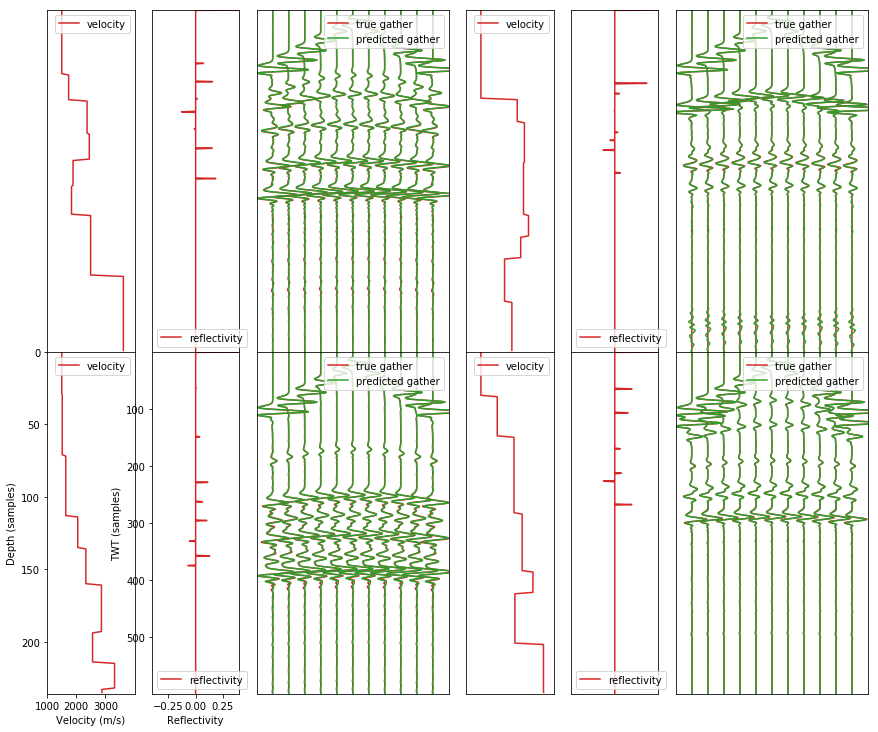

Average prediction time: 0.02997 s


In [10]:
# Hint: to run some predictions, use the following code:

c["DATA_PATH"]="data/layers_8ms.bin"# ensure data path set correctly in loaded constants file

# grab some test data
dataset = datasets.SeismicDataset(c)
velocity_array, reflectivity_array, gather_array = dataset[16000:16004]# the first four examples in the test dataset
print(reflectivity_array.shape)# (Note slicing a SeismicDataset object returns a batch of examples)

# run a model prediction
gather_prediction_array = sess.run(model.y, feed_dict={reflectivity: reflectivity_array})
print(gather_prediction_array.shape)

### TODO: Enter your code to visualise the model predictions here:

model._plot_results(reflectivity_array,# add a batch dimension
                    gather_prediction_array,
                    gather_array,
                    velocity_array)
plt.show()

### TODO: Enter your code to time the prediction step here:

reflectivity_array = dataset[16000:16100][1]# batch of 100 reflectivity arrays
start = time.time()
gather_prediction_array = sess.run(model.y, feed_dict={reflectivity: reflectivity_array})
print("Average prediction time: %.5f s"%((time.time()-start)/100.))

### Extension (optional): you could try feeding the model velocity models outside of its training data
### distribution e.g. ones with smoothly varying velocity values (instead of layers) - and evaluate 
### how stable the model predictions appear in this case.

# Section 5: Seismic inversion (optional extra)

We can also use the same WaveNet architecture to carry out **seismic inversion** of this datset: namely, given a set of receiver recordings, can we invert for the underlying velocity model?

For this model, we can simply **reverse the inputs and outputs** of our WaveNet model and retrain the model!

The provided `models.SeismicWavenet` class is expressive enough to handle this; whether the model carries out forward or inverse modelling can be controlled by its `SeismicWavenet(inverse=True)` input flag. When wrapping `SeismicWavenet` with the `main.Trainer` class, this flag can be set via the `constants.Constants` class, ie, setting `c["inverse"]=True`.

> **Optional Task 1**: re-use the code above to train a model which carries out seismic inversion. 

> **Optional Task 2:** Visualise the results of your model by adapting your code from Task 7. 

If training is too expensive, you can use the pretrained model file and events file in `data/pretrained/inverse/` provided to help you. 

INFO:tensorflow:Restoring parameters from data/pretrained/inverse/model.ckpt-500000


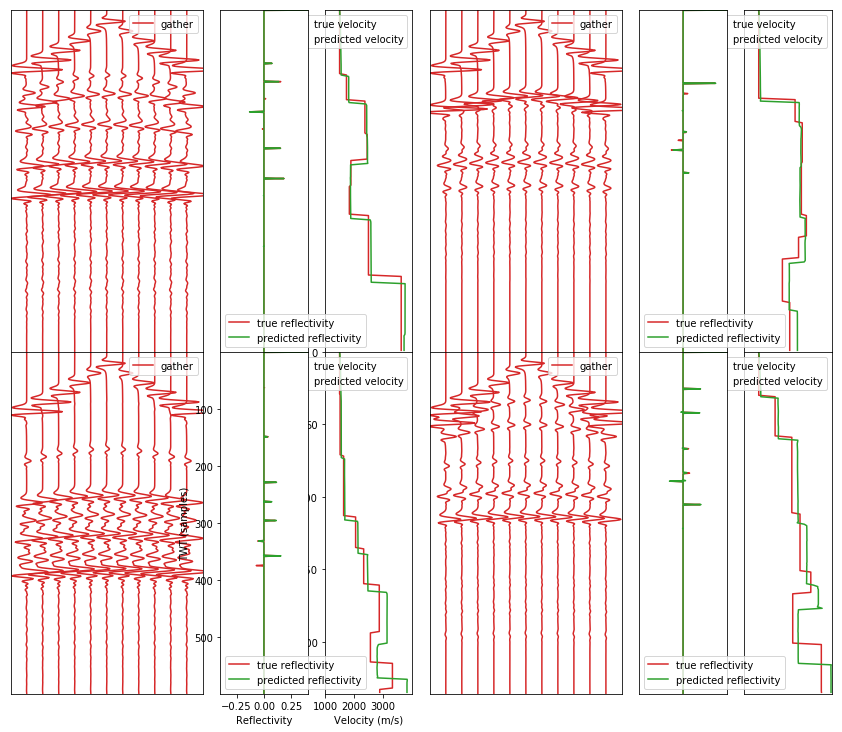

In [11]:
# TODO: Enter your code to train/ visualise the inverse modelling here:

# hint: the processing_utils.get_velocity_trace() function can convert a predicted
# reflectivity series to its corresponding velocity trace

tf.reset_default_graph()

# load pre-trained model
MODEL_LOAD_PATH = "data/pretrained/inverse/model.ckpt-500000"
CONSTANTS_LOAD_PATH = "data/pretrained/inverse/constants_inverse.pickle"

# load the model's saved constants object
c_dict = constants.load_constants_dict(CONSTANTS_LOAD_PATH)
c = constants.Constants(**c_dict)

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define and load model
model = models.SeismicWavenet(c, input_features)
model.define_graph()
model.define_loss()
saver = tf.train.Saver()# for loading model
sess = tf.Session()
saver.restore(sess, MODEL_LOAD_PATH)# restore weights

# grab some test data, plot results
velocity_array, reflectivity_array, gather_array = dataset[16000:16004]# the first four examples in the test dataset
reflectivity_prediction_array = sess.run(model.y, feed_dict={gather: gather_array})
model._plot_results(gather_array,# add a batch dimension
                    reflectivity_prediction_array,
                    reflectivity_array,
                    velocity_array)
plt.show()